# Ports

Ports are terminals through which electromagnetic waves can enter or exit a system.
In PhotonForge, they are 2D surfaces used to connect a component to the external world.
The [S parameters](S_Parameters.ipynb) of a device describes how the electromagnetic fields entering through its ports are transmitted within the component and exit through those same ports.

A [technology](../_autosummary/photonforge.Technology.rst) in PhotonForge comes with a number of predefined [port specifications](../_autosummary/photonforge.PortSpec.rst), which describe the waveguide cross-section represented by that port.

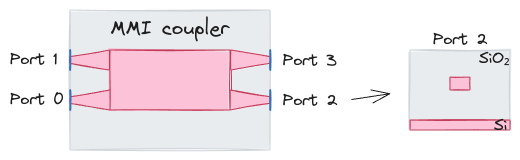

## Inspecting Ports

We will use the [basic technology](../_autosummary/photonforge.basic_technology.rst) as an example of technology from a PDK.
The [ports](../_autosummary/photonforge.Technology.rst#photonforge.Technology.ports) defined in the technology can be easily inspected:

In [1]:
import photonforge as pf

tech = pf.basic_technology()
pf.config.default_technology = tech

tech.ports

Name  Classification       Description       Width (μm)     Limits (μm)     Radius (μm)  Modes  Target n_eff         Path profiles (μm)               Voltage path                 Current path          
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CPW      electrical    CPW transmission line   26.0552    -9.05312, 12.9931       0       1 + 1       4        'gnd1'@'METAL': 8.9776 (+8.7888…  (4.3, 1.97) (1.8, 1.97)  (3.05, 3.47) (-3.05, 3.47) (-3.…
Rib       optical      Rib waveguide             2.16          -1, 1.22           0         1         4        'WG_CLAD': 2.4, 'SLAB': 2.4, 'W…                                                           
Strip     optical      Strip waveguide           2.25          -1, 1.22           0         1         4        'WG_CLAD': 2.5, 'WG_CORE': 0.5

As we can see, the basic technology comes with 3 predefined port specifications: "Strip", "Rib", and "CPW", corresponding to waveguides of different cross sections.

The specification [width](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.width) defines the lateral dimension of the waveguide cross-section, including the margins required for evanescent fields in dielectric waveguides.
Similarly, the [limits](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.limits) contain the lower and upper boundary coordinates for the cross-section in the out-of-plane (z) direction.
The actual shapes and materials of the waveguide are defined by its [path profiles](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.path_profiles), which contain `(width, offset, layer)` tuples.
These tuples are used to generate straight path sections when generating the actual waveguide.

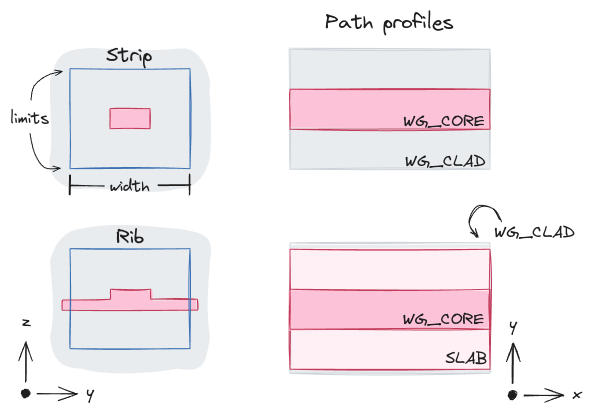

The extrusion profile for the waveguides can be quickly inspected through the [tidy3d_plot](../_autosummary/photonforge.tidy3d_plot.rst) function:

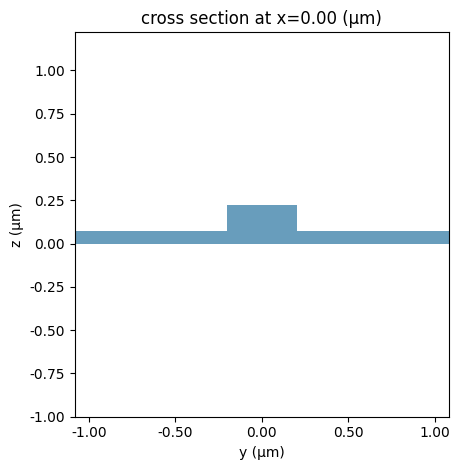

In [2]:
_ = pf.tidy3d_plot(tech.ports["Rib"])

Other attributes of the port specification define its supported modes.
In particular, [num_modes](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.num_modes) defines the number of modes used in this specification.
For the strip waveguide, `num_modes == 1`, which means it will support only the fundamental quasi-TE mode.
If we wanted to support the first quasi-TM mode too, we could set `num_modes = 2`.
However, if we wanted to support *only the quasi-TM mode*, we would keep `num_modes == 1` and set `added_solver_modes = 1`.
What [added_solver_modes](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.added_solver_modes) does is include extra modes in the mode solver run, but skip them later, so, in this case, we would solver for 2 modes (TE and TM) and skip the first (TE), keeping only the quasi-TM mode we want.

Computing the port specification modes can be easily done though Tidy3D's mode solver by exporting the specification [to tidy3d](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.to_tidy3d) or directly by using the [port_modes](../_autosummary/photonforge.port_modes.rst) function (which uses cached the results).

Loading cached simulation from .tidy3d/pf_cache/D4E/ms_info-MVFH6DWSA7I3LLCJWDVQHHRBYUTNHN24LCPG3PIV6PHGUAY2SGAA.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.401761    0.0          0.976936   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.815679         0.80411    0.20895

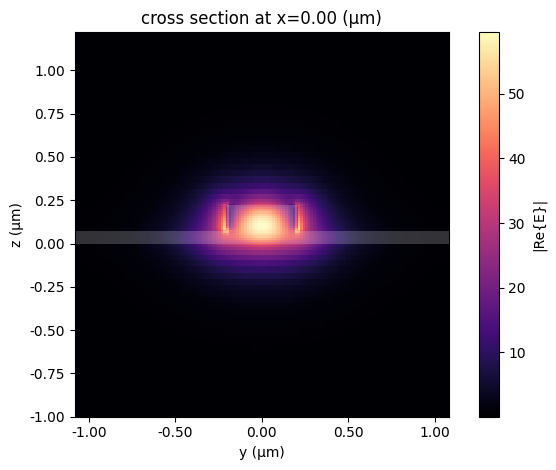

In [3]:
# Increase the mesh refinement for better resolution in field plots
pf.config.default_mesh_refinement = 30

freqs = [pf.C_0 / 1.55]

mode_solver = pf.port_modes("Rib", freqs)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

Finally, additional parameters are available exclusively for [electrical port specifications](Electrical_Ports.ipynb).
Because we are focusing at [optical frequencies](../_autosummary/photonforge.frequency_classification.rst), we will not dive further into those parameters in this guide.

## Custom Port Specification

If we need to use a custom waveguide profile, it's easy to create a new port specification.
For example, let's add a multimode strip profile with an 800 nm core width, and a vertical slot waveguide.
Note that we follow the technology defaults of including the cladding region surrounding the waveguide core in the "WG_CLAD" layer `(1, 0)`, expanding beyond the port width.

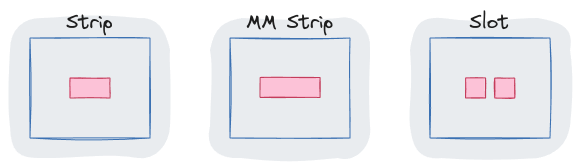

Loading cached simulation from .tidy3d/pf_cache/Y26/ms_info-I5CYO5CKYUM4YOJHX2HEK4ILQH7XCR3NW3VG4KSI4OD5OUNUGV3Q.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.663304    0.0          0.995820   
             1                 1.55  2.069936    0.0          0.955442   
             2                 1.55  1.895900    0.0          0.035859   
             3                 1.55  1.492316    0.0          0.153387   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.879224        0.809469   0.200003  
             1                 0.619598        0.861441   0.346613  
             2                 0.649337        0.918922   0.400217  
             3                 0.848186        0.666600   0.772814

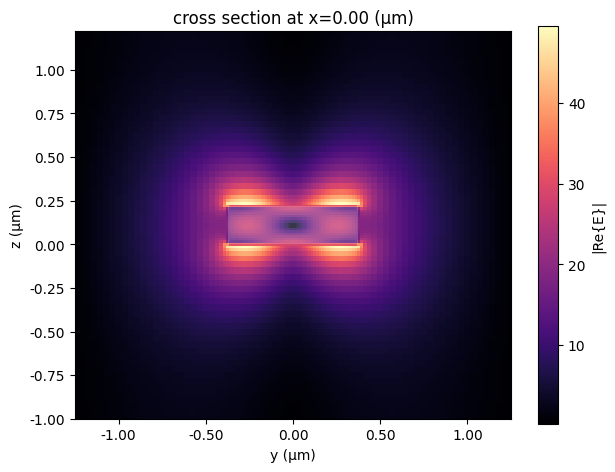

In [4]:
strip_mm = pf.PortSpec(
    "Multimode strip waveguide",
    width=2.5,
    limits=tech.ports["Strip"].limits,
    num_modes=4,
    target_neff=4,
    path_profiles={(2.6, 0, (1, 0)), (0.75, 0, (2, 0))},
)

mode_solver = pf.port_modes(strip_mm, freqs)
mode_solver.plot_field("E", mode_index=3, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

Loading cached simulation from .tidy3d/pf_cache/TGM/ms_info-MCMOMIZJFWUTA2YDGDUE4RORM2HQWODPIBV6KVI64EVZHUD7IVAA.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.666345    0.0          0.965873   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.869748        0.853841   0.179504

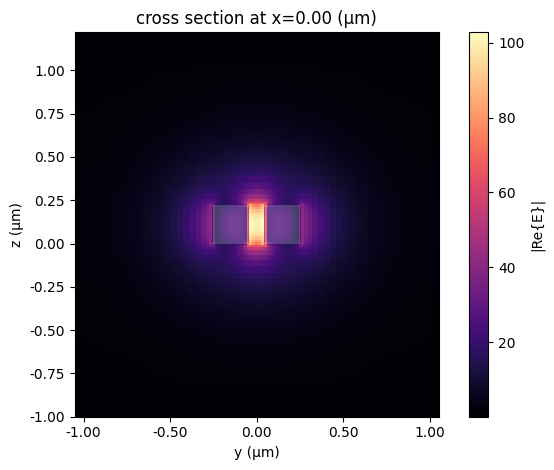

In [5]:
slot = pf.PortSpec(
    "Slot waveguide",
    width=2.1,
    limits=tech.ports["Strip"].limits,
    num_modes=1,
    target_neff=4,
    path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))},
)

mode_solver = pf.port_modes(slot, freqs)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

We can even [add](../_autosummary/photonforge.Technology.rst#photonforge.Technology.add_port) our new specifications to the technology, if we want to:

In [6]:
tech.add_port("Strip MM", strip_mm)
tech.add_port("Slot", slot)

tech.ports

Name    Classification         Description         Width (μm)     Limits (μm)     Radius (μm)  Modes  Target n_eff         Path profiles (μm)               Voltage path                 Current path          
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CPW         electrical    CPW transmission line       26.0552    -9.05312, 12.9931       0       1 + 1       4        'gnd1'@'METAL': 8.9776 (+8.7888…  (4.3, 1.97) (1.8, 1.97)  (3.05, 3.47) (-3.05, 3.47) (-3.…
Rib          optical      Rib waveguide                 2.16          -1, 1.22           0         1         4        'WG_CLAD': 2.4, 'SLAB': 2.4, 'W…                                                           
Slot         optical      Slot waveguide                2.1           -1, 1.22           0         1         4        'WG_CLAD': 2.2, 'WG_CORE': 0.2 …                                                           
Strip        optical      Strip waveguide               2.25          -1, 1.22           0         1         4        'WG_CLAD': 2.5, 'WG_CORE': 0.5                                                             
Strip MM     optical      Multimode strip waveguide     2.5           -1, 1.22           0         4         4        'WG_CORE': 0.75, 'WG_CLAD': 2.6

### Modifying Parametric Technologies

If a parametric technology is [updated](../_autosummary/photonforge.Technology.rst#photonforge.Technology.update) (in a Monte Carlo analysis, for example), the added port specifications will be lost.
The proper way of adding a port specification to a pre-existing parametric technology is to wrap it:

In [7]:
@pf.parametric_technology
def custom_basic_technology(*args, **kwargs):
    technology = pf.basic_technology(*args, **kwargs)
    slot = pf.PortSpec(
        "Slot waveguide",
        width=2.1,
        limits=tech.ports["Strip"].limits,
        num_modes=1,
        target_neff=4,
        path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))},
    )
    technology.add_port("Slot", slot)
    return technology


custom_tech = custom_basic_technology()
pf.config.default_technology = custom_tech

custom_tech.ports

Name  Classification       Description       Width (μm)     Limits (μm)     Radius (μm)  Modes  Target n_eff         Path profiles (μm)               Voltage path                 Current path          
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CPW      electrical    CPW transmission line   26.0552    -9.05312, 12.9931       0       1 + 1       4        'gnd1'@'METAL': 8.9776 (+8.7888…  (4.3, 1.97) (1.8, 1.97)  (3.05, 3.47) (-3.05, 3.47) (-3.…
Rib       optical      Rib waveguide             2.16          -1, 1.22           0         1         4        'WG_CLAD': 2.4, 'SLAB': 2.4, 'W…                                                           
Slot      optical      Slot waveguide            2.1           -1, 1.22           0         1         4        'WG_CLAD': 2.2, 'WG_CORE': 0.2 …                                                           
Strip     optical      Strip waveguide           2.25          -1, 1.22           0         1         4        'WG_CLAD': 2.5, 'WG_CORE': 0.5

Loading cached simulation from .tidy3d/pf_cache/N7T/ms_info-AZZCYJPO7HU633E2YM3MZKDL63SHQTJ5K3JGLHD4ZBGNIBT7AGFQ.json.


Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.476473    0.0          0.981362   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                  0.95132        0.905711   0.776191

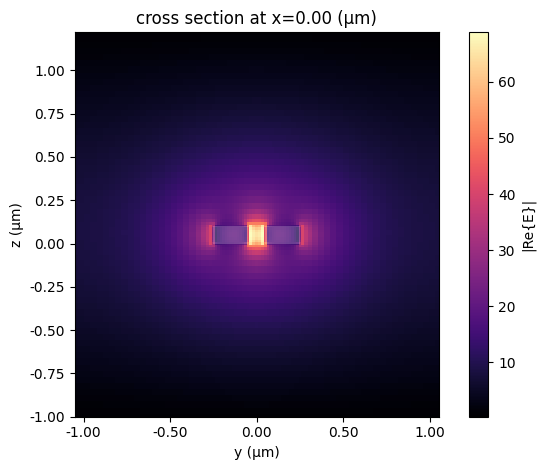

In [8]:
custom_tech.update(core_thickness=0.1)

mode_solver = pf.port_modes("Slot", freqs)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

## Waveguides

We can easily create a waveguide corresponding to a port specification using the [get_paths](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.get_paths) function:

In [9]:
strip = tech.ports["Slot"]

# Use a component for setting layers and visualization
connection = pf.Component("CONNECTION")

for layer, path in strip.get_paths((0, 0)):
    path.segment((5, 0)).turn(90, 4).segment((9, 6))
    connection.add(layer, path)

connection

## Adding Ports to a Component

To [add](../_autosummary/photonforge.Component.rst#photonforge.Component.add_port) a [port](../_autosummary/photonforge.Port.rst) to a component, we first need to create it by setting its position, orientation (input direction) and specification.

In [10]:
port0 = pf.Port((0, 0), 0, "Slot")

# Set the port name to "P0"
connection.add_port(port0, "P0")

connection

Another option is to use port [auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports) to look for possible ports in the component.

Auto-detection works by matching the required path profiled in the port specifications to the **edges** in the component geometry, which means:

1. There can be false positives if a port profile is very simple and it matches several edges in the component geometry.

   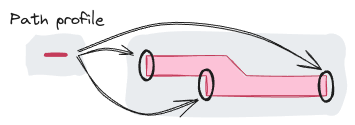

3. Ports will not be found if, for example, a clad layer is required to surround the waveguide core, but only the core edge is found

   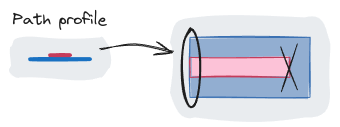

In [11]:
detected_ports = connection.detect_ports(["Slot"])
detected_ports

[Port(center=(9, 6), input_direction=270, spec=PortSpec(description="Slot waveguide", width=2.1, limits=(-1, 1.22), num_modes=1, added_solver_modes=0, polarization="", target_neff=4, default_radius=0, path_profiles=[(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))]), extended=True, inverted=False, bend_radius=0)]

Note that the auto-detection skipped the port at (0, 0) because it was already present in the component (it does not create duplicates).

In [12]:
connection.add_port(detected_ports[0], "P1")
connection